## reference:

If you use this code for a publication, please reference as:
arXiv:2008.04626: https://arxiv.org/abs/2008.04626

In [ ]:
%matplotlib inline

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
from scipy import *
from scipy import fftpack
import scipy.optimize as optimize
import scipy.signal.windows as fft_windows
from pylab import *
import time

In [ ]:
def XRR(data, crit_ang):
    """
    Returns equally spaced data for the Fourier analysis of a typical XRR dataset.
    Data must be an array with 2 Theta angle in the first column and the intensity in the second column
    """

    # rescale x-axis to get at the end nm from the FFT (introduce diffraction vector: s_cor)
    s_cor = (
        2
        * np.sqrt(
            (np.cos(np.pi * crit_ang / 2 / 180)) ** 2
            - (np.cos(np.pi * data[:, 0] / 2 / 180)) ** 2
        )
        / 0.152
    )

    # mask all entrys which are 'nan' due to values below the critical angle
    mask = np.logical_not(np.isnan(s_cor))
    s_cor = s_cor[mask]

    # subtract a background of 'theta^4 * intensity'
    intensity = s_cor**4 * data[mask, 1]

    # create new x wave with even spacing going from the lowest
    # to the highest diffraction vector
    x = np.linspace(s_cor.min(), s_cor.max(), 1000)
    f = scp.interpolate.interp1d(s_cor, intensity, kind="cubic")
    return x, f(x)


def FFT(x, y, d=None, window=2, n=None):
    """
    Performs a (real) FFT using no window (0), a hanning (1), a hamming (2) or flattop (otherwise) window.
    d is data spacing; if no d is given, the spacing of the first two data values in x is taken
    x data have to be equaly spaced!
    n = number of values taken into account, if n<len(y): data are cropped; if n>len(y): data are zero-padded
    returns only one half of the full FFT (1st quadrant)
    """
    if d is None:
        d = x[1] - x[0]
    N = len(y)
    # declaration of window functions
    if 0 == window:
        window = np.ones(N)
    elif 1 == window:
        window = fft_windows.hann(N)
    elif 2 == window:
        window = fft_windows.hamming(N)
    else:
        window = fft_windows.flattop(N)
    if n is None:
        n = N
    # calculate fft with all correction factors:
    # 2/N: up front to renormalize the FFT
    # mean(window): window correction factor
    yf = 2 / N * np.abs(scp.fftpack.fft(window * y / np.mean(window), n=n))
    # Calculate the frequency axis
    xf = scp.fftpack.fftfreq(n, d=d)
    return xf[: n // 2], yf[: n // 2]

In [ ]:
from google.colab import drive
import numpy as np

drive.mount("/content/drive")  # 처음 한 번만 인증
# 예시 경로: MyDrive/Data/XRR/ml20191202b_2.xy
path = "/content/drive/MyDrive/Colab Notebooks/ml20191202b_2.xy"
y40 = np.genfromtxt(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-9-a03690a7bae2>:8: RuntimeWarning: invalid value encountered in sqrt
  s_cor = 2*np.sqrt((np.cos(np.pi*crit_ang/2/180))**2 -


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

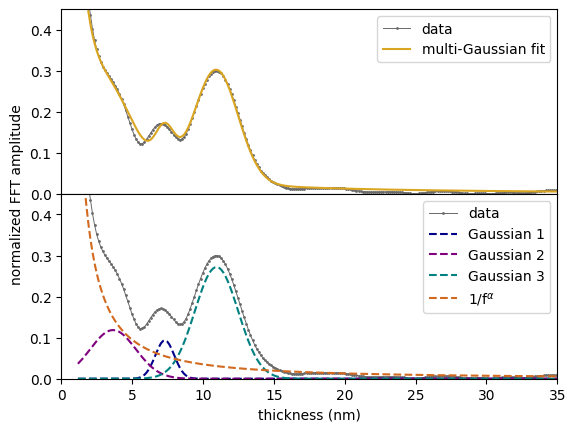

Gaussian full
- a1: 0.12, p1:3.65nm, w1:3.80nm
- a2: 0.09, p2:7.30nm, w2:1.58nm
- a3: 0.27, p3:10.96nm, w3:3.60nm
- Noise
- amp: 0.96, exp: 1.44
- z0: 0.00


In [ ]:
# define data set
dat = y40

crit = 0.6  # manually determined

################## FFT ##############################################################################

# to compare the padded data to the "normal" data: normalize y-axes to first value
# for normalization of padded data
FFTpadx = FFT(*XRR(dat, crit), window=2, n=10000)[0]
FFTpady = FFT(*XRR(dat, crit), window=2, n=10000)[1]

# padded data: normalize y-axis to first value
FFTpady_n = FFTpady / FFTpady[0]

################## mask the spectrum to fit separate regions #########################################

# mask for only fitting the 1/f background; remove any peaks
mask5 = logical_or(
    logical_and(FFTpadx > 1, FFTpadx < 5), logical_and(FFTpadx > 26, FFTpadx < 80)
)
xmask5 = FFTpadx[mask5]
ymask5 = FFTpady_n[mask5]

# mask for full spectrum fit; remove initial points to avoid always getting a peak in the initial 1/f background
mask6 = logical_and(FFTpadx > 1.1, FFTpadx < 80)
xmask6 = FFTpadx[mask6]
ymask6 = FFTpady_n[mask6]

####################################################################################################

# fitting


####################################################################################################
# 1/f fitting
def funcNoise(x, amp, ex):
    return amp / pow(x, ex)  # y-offset = white noise


poptfNoise, pcovfNoise = optimize.curve_fit(funcNoise, xmask5, ymask5)
# print('poptfNoise:{}'.format(poptfNoise))


################################################################################################
# gaussian fitting
def funcGauss(p, a, pmax, w):
    return a * exp(-log(2) * ((pmax - p) / (w / 2)) ** 2)


def funcGauss2(p, a1, a2, pmax1, pmax2, w1, w2):
    return funcGauss(p, a1, pmax1, w1) + funcGauss(p, a2, pmax2, w2)


def funcGauss3(p, a1, w1, a2, pmax2, w2, a3, pmax3, w3, amp, ex, z0):
    pmax1 = pmax3 - pmax2
    return (
        funcGauss2(p, a1, a2, pmax1, pmax2, w1, w2)
        + funcGauss(p, a3, pmax3, w3)
        + funcNoise(p, amp, ex)
        + z0
    )


poptGauss3, pcovGauss3 = optimize.curve_fit(
    funcGauss3,
    xmask6,
    ymask6,
    p0=[0.2, 0.3, 0.2, 7, 0.3, 0.2, 13, 0.3, 1, 2, 2e-3],
    bounds=(0, inf),
)

# print(pcovGauss3)
######################################################################################################

# plotting

######################################################################################################

# Gaussian

f, ax = subplots(2, 1, sharex=True, sharey=True)

# plot data (FFT + zero padding)
ax[0].plot(
    FFTpadx, FFTpady_n, "o-", markersize=1, linewidth=0.7, color="dimgrey", label="data"
)
ax[1].plot(
    FFTpadx, FFTpady_n, "o-", markersize=1, linewidth=0.7, color="dimgrey", label="data"
)

# plot fit
ax[0].plot(
    xmask6,
    funcGauss3(xmask6, *poptGauss3),
    "-",
    color="goldenrod",
    label="multi-Gaussian fit",
)


# plot single graphs with parameters from combined fit
ax[1].plot(
    xmask6,
    funcGauss(xmask6, *poptGauss3[2:5]),
    "--",
    color="darkblue",
    label="Gaussian 1",
)
ax[1].plot(
    xmask6,
    funcGauss(xmask6, poptGauss3[0], poptGauss3[6] - poptGauss3[3], poptGauss3[1]),
    "--",
    color="purple",
    label="Gaussian 2",
)
ax[1].plot(
    xmask6, funcGauss(xmask6, *poptGauss3[5:8]), "--", color="teal", label=r"Gaussian 3"
)
ax[1].plot(
    xmask6,
    funcNoise(xmask6, *poptGauss3[8:10]),
    "--",
    color="chocolate",
    label=r"1/f$^\alpha$",
)


ax[0].set_ylabel(r"normalized FFT amplitude", y=0)
ax[1].set_xlabel(r"thickness (nm)")


ax[0].set_xlim(0, 35)
ax[0].set_ylim(0, 0.45)

ax[0].legend()  # loc='lower right')
ax[1].legend()  # loc='lower right')
# ax[2].legend()

f.subplots_adjust(hspace=0)
plt.show()

print("Gaussian full")
print(
    "- a1: {:.2f}, p1:{:.2f}nm, w1:{:.2f}nm".format(
        poptGauss3[0], poptGauss3[6] - poptGauss3[3], poptGauss3[1]
    )
)
print("- a2: {:.2f}, p2:{:.2f}nm, w2:{:.2f}nm".format(*poptGauss3[2:5]))
print("- a3: {:.2f}, p3:{:.2f}nm, w3:{:.2f}nm".format(*poptGauss3[5:8]))
print("- Noise")
print("- amp: {:.2f}, exp: {:.2f}".format(poptGauss3[8], poptGauss3[9]))
print("- z0: {:.2f}".format(poptGauss3[10]))